In [5]:
import os
import numpy as np
import pandas as pd
import pystan
import copy
import math
import matplotlib.pyplot as plt
STAN_FIT_DIR = "stan{}fits{}".format(os.sep, os.sep)
STAN_MODEL_DIR = "stan{}src{}".format(os.sep, os.sep)
STAN_MODEL_CACHE = "stan{}model-cache".format(os.sep)

DATA_DIR = "..{}data{}".format(os.sep, os.sep)

MONTHS = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
LEAPS = [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
WANTEDFEWSFOOD = {'Cowpeas (Red)'}
WANTEDSTATIONS = {'EGAL INTL'}


def getDays(year, quarter):
    if (year % 4 == 0):
        return [0, 91, 91, 92, 92][quarter]
    else:
        return [0, 90, 91, 92, 92][quarter]


def getDate(year, month, day):
    if (year % 4 == 0):
        return year + (np.cumsum(LEAPS)[month - 1] + day - 1) / 366.
    else:
        return year + (np.cumsum(MONTHS)[month - 1] + day - 1) / 365.


In [6]:
import pandas as pd


def load_data(regions):
    print("Loading data for all regions")

    data_by_region = dict()

    for region in regions:
        data_by_region[region] = get_famine_data(region)

    return data_by_region


def calculate_datasets(regions, data_by_region):
    datasets_by_region = dict()

    for region in regions:

        if data_by_region[region] is None:
            print("Region {} not defined, skipping".format(region))
            datasets_by_region[region] = None
            continue

        datasets = dict()

        food_items = data_by_region[region]["_food_items"]
        ffood_items = data_by_region[region]["_ffood_items"]

        ipc_df = data_by_region[region]["ipc_df"]
        food_df = data_by_region[region]["food_df"]
        ffood_df = data_by_region[region]["ffood_df"]
        conflict_df = data_by_region[region]["conflict_df"]
        weather_df = data_by_region[region]["weather_df"]

        start_year = data_by_region[region]['_start_year']
        end_year = data_by_region[region]['_end_year']
        start_quarter = data_by_region[region]['_start_quarter']
        end_quarter = data_by_region[region]['_end_quarter']

        for year in range(start_year, end_year + 1):
            first_quarter = start_quarter if year == start_year else 1
            last_quarter = end_quarter if year == end_year else 4

            for quarter in range(first_quarter, last_quarter + 1):
                nDays = getDays(year, quarter)
                dataset = dict()
                ipc_row = ipc_df.loc[ipc_df.Year.eq(year) & ipc_df.Quarter.eq(quarter)]

                if (len(ipc_row) == 1):
                    dataset['P2'] = ipc_row.P2perc.values[0]
                    dataset['P3'] = ipc_row.P3perc.values[0]
                    dataset['P4'] = ipc_row.P4perc.values[0]

                features = []

                for item in food_items:
                    market = food_df[food_df.Item.eq(item)].Market.values[0]
                    t_item_df = food_df[food_df.Year.eq(year) & food_df.Quarter.eq(quarter) & food_df.Item.eq(item)]

                    features.append(np.mean(t_item_df.Price.values) / 1e4)

                for item in ffood_items:
                    market = ffood_df[ffood_df.Item.eq(item)].Market.values[0]
                    t_item_df = ffood_df[ffood_df.Year.eq(year) & ffood_df.Quarter.eq(quarter) & ffood_df.Item.eq(item)]

                    features.append(np.mean(t_item_df.Price.values) / 1e4)

                t_conflict_df = conflict_df[conflict_df.Year.eq(year) & conflict_df.Quarter.eq(quarter)]

                features.append(np.sum(t_conflict_df.Fatalities.values) / nDays)

                t_weather_df = weather_df[weather_df.Year.eq(year) & weather_df.Quarter.eq(quarter)]
                cycle = 1

                while (len(t_weather_df) != 3):
                    t_weather_df = weather_df[weather_df.Year.eq(year + cycle) & weather_df.Quarter.eq(quarter)]
                    cycle += 1

                features.append(np.mean(t_weather_df.Temperature.values))

                dataset['features'] = features
                datasets[year * 10 + quarter] = dataset
        datasets_by_region[region] = datasets
        print("Famine dataset calculated for {}".format(region))
    return datasets_by_region


def get_famine_data(region):
    print("Loading famine data for {}".format(region))
    # Transform food data:
    data = dict()

    feature_names = []
    value_columns = dict()

    ## Food Data
    food_df = pd.read_csv(DATA_DIR + 'clean_food.csv')
    food_df = food_df[food_df.Region.eq(region)]
    food_df["Item_Name"] = food_df.Item + " - " + food_df.Market
    data['food_df'] = food_df

    food_items = sorted(set(food_df.Item.values))
    food_item_names = sorted(set(food_df.Item_Name.values))
    for food_item in food_items:
        market = food_df[food_df.Item.eq(food_item)].Market.values[0]
        fn = "{} - {}".format(food_item, market)
        feature_names.append(fn)
        value_columns[fn] = "Price"

    # Constrained by food data dates, get the earliest and latest dates here:
    e_y = min(food_df.Year.values)
    e_q = min(food_df[food_df.Year.eq(e_y)].Quarter.values)
    l_y = max(food_df.Year.values)
    l_q = max(food_df[food_df.Year.eq(l_y)].Quarter.values)

    ## FFood Data
    ffood_df = pd.read_csv(DATA_DIR + 'clean_fews.csv')
    ffood_df = ffood_df[ffood_df.Item.isin(WANTEDFEWSFOOD) & ffood_df.Region.eq(region)]
    ffood_df = ffood_df[(ffood_df.Year.eq(e_y) & ffood_df.Quarter.ge(e_q)) | (ffood_df.Year.gt(e_y))]
    ffood_df = ffood_df[(ffood_df.Year.eq(l_y) & ffood_df.Quarter.le(l_q)) | (ffood_df.Year.lt(l_y))]
    ffood_df["Item_Name"] = ffood_df.Item + " - " + ffood_df.Market
    data['ffood_df'] = ffood_df

    ffood_items = sorted(set(ffood_df.Item.values))
    ffood_item_names = sorted(set(ffood_df.Item_Name.values))
    for ffood_item in ffood_items:
        market = ffood_df[ffood_df.Item.eq(ffood_item)].Market.values[0]
        fn = "{} - {}".format(ffood_item, market)
        feature_names.append(fn)
        value_columns[fn] = "Price"

    ## Conflict Data
    conflict_df = pd.read_csv(DATA_DIR + "clean_conflict.csv")
    conflict_df = conflict_df[conflict_df.Region.eq(region)]
    conflict_df = conflict_df[(conflict_df.Year.eq(e_y) & conflict_df.Quarter.ge(e_q)) | (conflict_df.Year.gt(e_y))]
    conflict_df = conflict_df[(conflict_df.Year.eq(l_y) & conflict_df.Quarter.le(l_q)) | (conflict_df.Year.lt(l_y))]

    # Aggregate over months
    monthly_conflict_df = pd.DataFrame(columns=["Region", "Date", "Fatalities", "Year", "Month", "Quarter"])
    for year in range(e_y, l_y):
        f_q = e_q if year == e_y else 1
        s_q = l_q if year == l_y else 4
        for quarter in range(f_q, s_q + 1):
            for month in range((quarter - 1) * 3 + 1, quarter * 3 + 1):
                month_df = conflict_df[conflict_df.Year.eq(year) & conflict_df.Month.eq(month)]
                new_row = dict(
                    Region=region,
                    Year=year,
                    Month=month,
                    Quarter=quarter,
                    Date=getDate(year, month, 1),
                    Fatalities=sum(month_df.Fatalities.values)
                )
                monthly_conflict_df = monthly_conflict_df.append(new_row, ignore_index=True)

    monthly_conflict_df = monthly_conflict_df.sort_values(by="Date")
    data['conflict_df'] = monthly_conflict_df
    value_columns["{} - Fatalities due to Conflict".format(region)] = "Fatalities"

    feature_names.append("{} - Fatalities due to Conflict".format(region))

    ipc_df = pd.read_csv(DATA_DIR + 'clean_ipc.csv')
    ipc_df = ipc_df[ipc_df.Region.eq(region)]
    ipc_df = ipc_df[(ipc_df.Year.eq(e_y) & ipc_df.Quarter.ge(e_q)) | (ipc_df.Year.gt(e_y))]
    ipc_df = ipc_df[(ipc_df.Year.eq(l_y) & ipc_df.Quarter.le(l_q)) | (ipc_df.Year.lt(l_y))]
    data['ipc_df'] = ipc_df

    weather_df = pd.read_csv(DATA_DIR + 'clean_weather.csv')
    weather_df = weather_df[weather_df.Station.isin(WANTEDSTATIONS)]
    weather_df = weather_df[(weather_df.Year.eq(e_y) & weather_df.Quarter.ge(e_q)) | (weather_df.Year.gt(e_y))]
    weather_df = weather_df[(weather_df.Year.eq(l_y) & weather_df.Quarter.le(l_q)) | (weather_df.Year.lt(l_y))]

    w_e_y = min(weather_df.Year.values)
    w_e_q = min(weather_df[weather_df.Year.eq(w_e_y)].Quarter.values)
    w_l_y = max(weather_df.Year.values)
    w_l_q = max(weather_df[weather_df.Year.eq(w_l_y)].Quarter.values)

    prev_temp = np.nan
    first_temp = np.nan
    nan_dates = []
    monthly_weather_df = pd.DataFrame(columns=["Station", "Date", "Temperature", "Year", "Month", "Quarter"])
    for year in range(w_e_y, w_l_y + 1):
        f_q = w_e_q if year == w_e_y else 1
        s_q = w_l_q if year == w_l_y else 4
        for quarter in range(f_q, s_q + 1):
            for month in range((quarter - 1) * 3 + 1, quarter * 3 + 1):
                month_df = weather_df[weather_df.Year.eq(year) & weather_df.Month.eq(month)]
                avg_temp = np.mean(month_df.Temperature.values)
                if (np.isnan(avg_temp)):
                    if (np.isnan(prev_temp)):
                        nan_dates.append(getDate(year, month, 1))
                    else:
                        avg_temp = prev_temp
                else:
                    if (np.isnan(first_temp)):
                        first_temp = avg_temp
                new_row = dict(
                    Station=list(WANTEDSTATIONS)[0],
                    Date=getDate(year, month, 1),
                    Temperature=avg_temp,
                    Year=year,
                    Month=month,
                    Quarter=quarter
                )
                monthly_weather_df = monthly_weather_df.append(new_row, ignore_index=True)
                prev_temp = avg_temp
    for date in nan_dates:
        monthly_weather_df.at[monthly_weather_df.Date.eq(date), 'Temperature'] = first_temp

    monthly_weather_df = monthly_weather_df.sort_values(by="Date")
    data['weather_df'] = monthly_weather_df

    feature_names.append("Temperature")
    value_columns["Temperature"] = "Temperature"

    if (len(ipc_df) <= 12):
        print("Insufficient data for region {}, trying to fit with data will give an over-fitted model".format(region))
        return None

    data["_feature_names"] = feature_names
    data["_value_columns"] = value_columns

    e_y = max(e_y, min(ipc_df.Year.values))
    e_q = max(e_q, min(ipc_df[ipc_df.Year.eq(e_y)].Quarter.values))
    data["_start_year"] = e_y
    data["_start_quarter"] = e_q
    data["_end_year"] = l_y
    data["_end_quarter"] = l_q

    data["_food_items"] = food_items
    data["_food_item_names"] = food_item_names
    data["_ffood_items"] = ffood_items
    data["_ffood_item_names"] = ffood_item_names

    return data

In [7]:
def predict_data(data, end_year, end_quarter):
    print("Calculating prediction data up to q{}/{}".format(end_quarter, end_year))
    new_data = copy.deepcopy(data)
    food_df = new_data['food_df']
    ffood_df = new_data['ffood_df']
    weather_df = new_data['weather_df']
    conflict_df = new_data['conflict_df']

    new_data["_end_year"] = end_year
    new_data["_end_quarter"] = end_quarter

    end_month = [0, 3, 6, 9, 12][end_quarter]
    end_day = [0, 31, 30, 30, 31][end_quarter]

    new_rows = []
    food_items = sorted(set(food_df.Item.values))
    for item in food_items:

        t_item_df = food_df[food_df.Item.eq(item)]

        market = t_item_df.Market.values[0]
        region = t_item_df.Region.values[0]
        last_year = max(t_item_df.Year.values)
        last_quarter = max(t_item_df[t_item_df.Year.eq(last_year)].Quarter.values)
        last_month = max(t_item_df[t_item_df.Year.eq(last_year)].Month.values)
        last_price = t_item_df.loc[t_item_df.Year.eq(last_year) & t_item_df.Month.eq(last_month)].Price.values[0]

        for new_year in range(last_year, end_year + 1):
            month_start = last_month + 1 if new_year == last_year else 1
            month_end = end_month + 1 if new_year == end_year else 13
            for new_month in range(month_start, month_end):
                new_rows.append(dict(
                    Date=getDate(new_year, new_month, 1),
                    Region=region,
                    Market=market,
                    Item=item,
                    Price=last_price,
                    Year=new_year,
                    Month=new_month,
                    Quarter=math.ceil(new_month / 3)
                ))
    food_df = food_df.append(new_rows).sort_values(by=['Item', 'Date']).reset_index(drop=True)
    food_df["Item_Name"] = food_df.Item + " - " + food_df.Market
    new_data['food_df'] = food_df

    ffood_items = sorted(set(ffood_df.Item))
    new_rows = []
    for item in ffood_items:

        t_item_df = ffood_df[ffood_df.Item.eq(item)]

        market = t_item_df.Market.values[0]
        region = t_item_df.Region.values[0]
        last_year = max(t_item_df.Year.values)
        last_quarter = max(t_item_df[t_item_df.Year.eq(last_year)].Quarter.values)
        last_month = max(t_item_df[t_item_df.Year.eq(last_year)].Month.values)
        last_price = t_item_df.loc[t_item_df.Year.eq(last_year) & t_item_df.Month.eq(last_month)].Price.values[0]

        for new_year in range(last_year, end_year + 1):
            if (last_month == 12 and new_year == last_year):
                continue
            month_start = last_month + 1 if new_year == last_year else 1
            month_end = end_month + 1 if new_year == end_year else 13
            for new_month in range(month_start, month_end):
                new_rows.append(dict(
                    Date=getDate(new_year, new_month, 1),
                    Region=region,
                    Market=market,
                    Item=item,
                    Price=last_price,
                    Year=new_year,
                    Month=new_month,
                    Quarter=math.ceil(new_month / 3)
                ))
    ffood_df = ffood_df.append(new_rows).sort_values(by=['Item', 'Date']).reset_index(drop=True)
    ffood_df["Item_Name"] = ffood_df.Item + " - " + ffood_df.Market
    new_data['ffood_df'] = ffood_df

    new_rows = []
    region = conflict_df.Region.values[0]
    last_year = max(conflict_df.Year.values)
    last_month = max(conflict_df[conflict_df.Year.eq(last_year)].Month.values)
    last_fatality = \
    conflict_df.loc[conflict_df.Year.eq(last_year) & conflict_df.Month.eq(last_month)].Fatalities.values[0]

    for new_year in range(last_year, end_year + 1):
        month_start = last_month + 1 if new_year == last_year else 1
        month_end = end_month + 1 if new_year == end_year else 13
        for new_month in range(month_start, month_end):
            new_rows.append(dict(
                Region=region,
                Date=getDate(new_year, new_month, 1),
                Fatalities=last_fatality,
                Year=new_year,
                Month=new_month,
                Quarter=math.ceil(new_month / 3)
            ))
    conflict_df = conflict_df.append(new_rows).sort_values(by=['Date']).reset_index(drop=True)
    new_data['conflict_df'] = conflict_df

    new_rows = []
    station = weather_df.Station.values[0]
    last_year = max(weather_df.Year.values)
    last_month = max(weather_df[weather_df.Year.eq(last_year)].Month.values)
    last_temperature = weather_df[weather_df.Year.eq(last_year) & weather_df.Month.eq(last_month)].Temperature.values[0]

    for new_year in range(last_year, end_year + 1):
        month_start = last_month + 1 if new_year == last_year else 1
        month_end = end_month + 1 if new_year == end_year else 13
        for new_month in range(month_start, month_end):
            new_rows.append(dict(
                Station=station,
                Date=getDate(new_year, new_month, 1),
                Temperature=last_temperature,
                Year=new_year,
                Month=new_month,
                Quarter=math.ceil(new_month / 3)
            ))
    weather_df = weather_df.append(new_rows).sort_values(by=['Date']).reset_index(drop=True)
    new_data['weather_df'] = weather_df
    new_data["_food_items"] = food_items
    new_data["_ffood_items"] = ffood_items
    
    return new_data

In [8]:
awdal_data = get_famine_data("Awdal")
predicted_data = predict_data(awdal_data, 2021, 4)

Loading famine data for Awdal
Calculating prediction data up to q4/2021


In [9]:
display(predicted_data)

{'food_df':             Date Region  Market           Item   Price  Year  Month  Quarter  \
 0    2015.000000  Awdal  Borama  Maize (white)  4000.0  2015      1        1   
 1    2015.084932  Awdal  Borama  Maize (white)  4000.0  2015      2        1   
 2    2015.161644  Awdal  Borama  Maize (white)  4000.0  2015      3        1   
 3    2015.246575  Awdal  Borama  Maize (white)  4000.0  2015      4        2   
 4    2015.328767  Awdal  Borama  Maize (white)  4000.0  2015      5        2   
 ..           ...    ...     ...            ...     ...   ...    ...      ...   
 247  2021.580822  Awdal  Borama  Sorghum (red)  4000.0  2021      8        3   
 248  2021.665753  Awdal  Borama  Sorghum (red)  4000.0  2021      9        3   
 249  2021.747945  Awdal  Borama  Sorghum (red)  4000.0  2021     10        4   
 250  2021.832877  Awdal  Borama  Sorghum (red)  4000.0  2021     11        4   
 251  2021.915068  Awdal  Borama  Sorghum (red)  4000.0  2021     12        4   
 
               

In [104]:
ark_code= '''
data {
  int<lower=0> K;
  int<lower=0> N;
  real y[N];
}
parameters {
  real alpha;
  real beta[K];
  real sigma;
}
model {
  for (n in (K+1):N) {
    real mu = alpha;
    for (k in 1:K)
      mu += beta[k] * y[n-k];
    y[n] ~ normal(mu, sigma);
  }
}'''

ark_model = pystan.StanModel(model_code=ark_code, model_name="ark_model")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL ark_model_294145ec0fd83ba8f5e7b184f55a0ea7 NOW.


In [94]:
ar5_code= '''
data {
  int<lower=0> K;
  int<lower=0> N;
  real y[N];
}
parameters {
  real alpha;
  real beta[K];
  real sigma;
}
model {
  for (n in (K+1):N) {
    y[n] ~ normal(alpha + beta[1]*y[n-5]+ beta[2]*y[n-4] + beta[3]*y[n-3]+ beta[4]*y[n-2]+ beta[5]*y[n-1], sigma);
  }
}'''

ar5_model = pystan.StanModel(model_code=ar5_code, model_name="ar5_model")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL ar5_model_b1ca69a24d3ec69e6053f91c5d6e469a NOW.


In [187]:
arma_code = '''
data {
  int<lower=0> K;
  int<lower=K> T;            // num observations
  real y[T];                 // observed outputs
}
parameters {
  real mu;                   // mean coeff
  vector<lower=-1, upper=1>[K] phi;             // autoregression coeff
  vector<lower=-1, upper=1>[K] theta;           // moving avg coeff
  real<lower=0> sigma;       // noise scale
}
model {
  vector[T] nu;              // prediction for time t
  vector[T] err;             // error for time t
  for (k in 1:K) {
      nu[k] = mu + phi[k] * mu;
      err[k] = y[k] - nu[k];
  }
  for (t in (K+1):T){
      nu[t] = mu;
      for (k in 1:K){
          nu[t] += phi[k]*y[t-k] + theta[k]*err[t-k];
      }
      err[t] = y[t] - nu[t];
  }
  mu ~ normal (0,1);
  phi ~ normal(0, 2);
  theta ~ normal(0, 2);
  sigma ~ cauchy(0, 5);
  err ~ normal(0, sigma);    // likelihood
} '''
arma_model = pystan.StanModel(model_code = arma_code, model_name="arma_model")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL arma_model_81d53e0c39bb7ab872d230527009fe6d NOW.


In [11]:
norm_dist_code = '''
data{
    int<lower=0> N;
    vector[N] t;
    vector[N] y;
}
parameters{
    real mu;
    real alpha;
    real<lower=0> sigma;
}
model{
    y ~ normal(mu+alpha*t, sigma);
}
'''
norm_model = pystan.StanModel(model_code = norm_dist_code, model_name="norm_model")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL norm_model_58dc611633735c8d2efcc4335d57a185 NOW.


In [59]:
ark_mod_code= '''
data {
  int<lower=0> K;
  int<lower=0> N;
  real y[N];
}
parameters {
  real alpha;
  real beta[K];
  real gamma;
  real<lower=0> sigma;
}
model {
  for (n in (K+1):N) {
    real mu = alpha + gamma*n;
    for (k in 1:K)
      mu += beta[k] * y[n-k];
    y[n] ~ normal(mu, sigma);
  }
}'''

ark_mod_model = pystan.StanModel(model_code=ark_mod_code, model_name="ark_mod_model")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL ark_mod_model_1fd053d4ea291cbb99368e94ed71431c NOW.


Inference for Stan model: ark_mod_model_1fd053d4ea291cbb99368e94ed71431c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.02  3.4e-4   0.01 -3.6e-3   0.02   0.02   0.03   0.05   1653    1.0
beta[1]    0.5  7.5e-3    0.3    -0.1    0.3    0.5   0.68   1.12   1637    1.0
beta[2]   0.41  7.7e-3   0.32   -0.23   0.21    0.4   0.61   1.04   1744    1.0
beta[3]  -0.38  5.2e-3   0.22   -0.79  -0.52  -0.38  -0.24   0.05   1748    1.0
gamma   3.3e-4  1.1e-5 5.3e-4 -7.1e-4 7.3e-6 3.3e-4 6.8e-4 1.4e-3   2334    1.0
sigma   4.5e-3  3.1e-5 1.1e-3  2.9e-3 3.7e-3 4.3e-3 5.0e-3 7.1e-3   1300    1.0
lp__     69.23    0.07   2.16   64.03  68.03  69.64  70.83  72.27    911    1.0

Samples were drawn using NUTS at Wed Feb 26 22:49:29 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduc

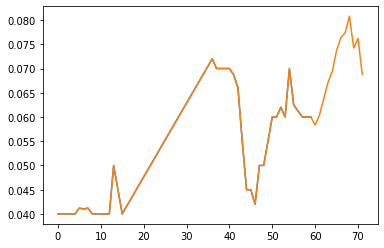

In [176]:
food_df = awdal_data["food_df"]
food_df = food_df[food_df.Item.eq("Maize (white)")]
#result = ark_mod_model.sampling(data = dict(N = 18, y = (food_df.Price.values/1e5).tolist()[-18:], K=3))
display(result)
all_coeffs =  list(map(lambda x: sum(x)/len(x), result.get_posterior_mean()))
alpha = all_coeffs[0]
beta = all_coeffs[1:4]
gamma = all_coeffs[4]
sigma = all_coeffs[5]

g = (food_df.Price.values/1e5).tolist()
pred = g[:]+[0 for _ in range(12)]
for i in range(len(food_df), len(food_df)+12):
    pred[i] = alpha + gamma*(i-len(food_df)+18) + np.sum(np.multiply(beta[::-1],pred[i-3:i])) + np.random.normal(scale=sigma)
plt.plot(g)
plt.plot(pred)
plt.show()

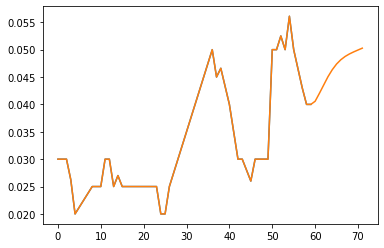

In [143]:
food_df = awdal_data["food_df"]
food_df = food_df[food_df.Item.eq("Sorghum (red)")]
result = ark_mod_model.sampling(data = dict(N = len(food_df), y = (food_df.Price.values/1e5).tolist(), K=3))
all_coeffs =  list(map(lambda x: sum(x)/len(x), result.get_posterior_mean()))
alpha = all_coeffs[0]
beta = all_coeffs[1:4]
gamma = all_coeffs[4]
sigma = all_coeffs[5]

g = (food_df.Price.values/1e5).tolist()
pred = g[:]+[0 for _ in range(12)]
for i in range(len(food_df), len(food_df)+12):
    pred[i] = alpha + gamma*i + np.sum(np.multiply(beta[::-1],pred[i-3:i])) #+ np.random.normal(scale=sigma)
plt.plot(g)
plt.plot(pred)
plt.show()

In [181]:
weather_df = awdal_data["weather_df"]
result = ark_mod_model.sampling(data = dict(N = len(weather_df), y = (weather_df.Temperature.values/1e2).tolist(), K=3))
display(result)

Inference for Stan model: ark_mod_model_1fd053d4ea291cbb99368e94ed71431c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
alpha      0.34  2.7e-3    0.1    0.16    0.27    0.34    0.4   0.53   1319    1.0
beta[1]    1.28  5.4e-3   0.18    0.92    1.16    1.28   1.39   1.61   1068   1.01
beta[2]   -0.74  7.9e-3   0.25   -1.25   -0.91   -0.74  -0.57  -0.24   1028   1.01
beta[3]    0.02  5.6e-3   0.18   -0.34    -0.1    0.02   0.14   0.37   1065   1.01
gamma   -1.1e-4  5.4e-6 3.4e-4 -7.8e-4 -3.4e-4 -1.2e-4 1.2e-4 5.6e-4   3978    1.0
sigma      0.03  7.5e-5 3.1e-3    0.02    0.02    0.03   0.03   0.03   1691    1.0
lp__      129.5    0.05   1.87  124.99  128.53  129.83 130.87 132.09   1248    1.0

Samples were drawn using NUTS at Wed Feb 26 22:51:58 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is t

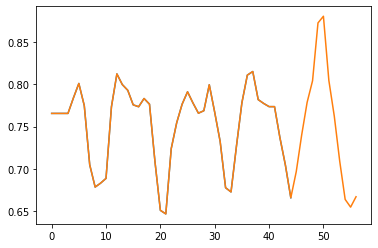

In [202]:

all_coeffs =  list(map(lambda x: sum(x)/len(x), result.get_posterior_mean()))
alpha = all_coeffs[0]
beta = all_coeffs[1:4]
gamma = all_coeffs[4]
sigma = all_coeffs[5]
g = (weather_df.Temperature.values/1e2).tolist()
pred = g[:]+[0 for _ in range(12)]
for i in range(len(weather_df), len(weather_df)+12):
    pred[i] = alpha + gamma*i + np.sum(np.multiply(beta[::-1],pred[i-3:i])) + np.random.normal(scale=sigma)
plt.plot(g)
plt.plot(pred)
plt.show()

In [207]:
conflict_df = awdal_data["conflict_df"]
display(conflict_df)
lam = np.mean(conflict_df.Fatalities.values)
np.random.poisson(lam = lam, size=100)

,Region,Date,Fatalities,Year,Month,Quarter
0,Awdal,2015.000000,0,2015,1,1
1,Awdal,2015.084932,0,2015,2,1
2,Awdal,2015.161644,0,2015,3,1
3,Awdal,2015.246575,0,2015,4,2
4,Awdal,2015.328767,0,2015,5,2
5,Awdal,2015.413699,0,2015,6,2
6,Awdal,2015.495890,0,2015,7,3
7,Awdal,2015.580822,1,2015,8,3
8,Awdal,2015.665753,0,2015,9,3
9,Awdal,2015.747945,3,2015,10,4


array([0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0])

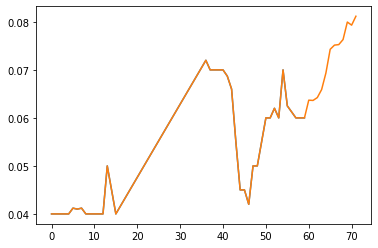

In [106]:
all_coeffs =  list(map(lambda x: sum(x)/len(x), result.get_posterior_mean()))
alpha = all_coeffs[0]
beta = all_coeffs[1:4]
gamma = all_coeffs[4]
sigma = all_coeffs[5]

g = (food_df.Price.values/1e5).tolist()
pred = g[:]+[0 for _ in range(12)]
for i in range(len(food_df), len(food_df)+12):
    pred[i] = alpha + gamma*i + np.sum(np.multiply(beta[::-1],pred[i-3:i])) + np.random.normal(scale=sigma)
plt.plot(g)
plt.plot(pred)
plt.show()

In [28]:
food_df = awdal_data["food_df"]
food_df = food_df[food_df.Item.eq("Maize (white)")]
result = norm_model.sampling(data = dict(N = 18, y = (food_df.Price.values/1e5).tolist()[-18:], t=range(18)))
print(result)

Inference for Stan model: norm_model_58dc611633735c8d2efcc4335d57a185.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.05  9.0e-5 3.3e-3   0.04   0.05   0.05   0.05   0.06   1380    1.0
alpha 7.6e-4  8.4e-6 3.3e-4 8.7e-5 5.5e-4 7.6e-4 9.8e-4 1.4e-3   1587    1.0
sigma 7.3e-3  6.1e-5 1.5e-3 4.7e-3 6.3e-3 7.1e-3 8.1e-3   0.01    598   1.01
lp__   75.45    0.05   1.36  71.97  74.77  75.79  76.47  77.07    880    1.0

Samples were drawn using NUTS at Wed Feb 26 22:20:21 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


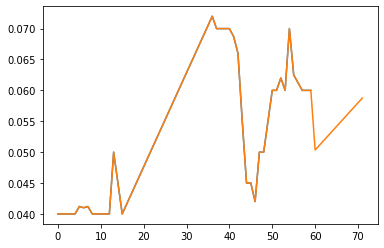

In [54]:
all_coeffs =  list(map(lambda x: sum(x)/len(x), result.get_posterior_mean()))
g = (food_df.Price.values/1e5).tolist()
mu = all_coeffs[0]
alpha = all_coeffs[1]
sigma = all_coeffs[2]
predicted = g[:]

for i in range(12):
    predicted.append(mu + alpha*i)#np.random.normal(loc=mu, scale=sigma) + alpha*i)
#predicted = g[:]+np.random.normal(loc=mu, scale=sigma, size=12).tolist()
plt.plot(g)
plt.plot(predicted)
plt.show()



In [17]:
food_df = awdal_data["food_df"]
food_df = food_df[food_df.Item.eq("Maize (white)")]
min_y = min(food_df.Year.values)
min_q = min(food_df[food_df.Year.eq(min_y)].Quarter.values)
max_y = max(food_df.Year.values)
max_q = max(food_df[food_df.Year.eq(max_y)].Quarter.values)
means = []
for year in range(min_y, max_y):
    q1 = min_q if min_y == year else 1
    q2 = max_q if max_y == year else 4
    for quarter in range(q1,q2+1):
        means.append(np.mean(food_df[food_df.Year.eq(year) & food_df.Quarter.eq(quarter)].Price.values))
        
#plt.plot(food_df.Price.values/1e5)
#result = arma_model.sampling(data = dict(T = len(means), y=means, K=3))
#print(food_df.Price.values/1e5)
result = arma_model.sampling(data = dict(T = len(food_df), y=food_df.Price.values/1e5, K=3), control={"max_treedepth":12})
print(result)

NameError: name 'arma_model' is not defined

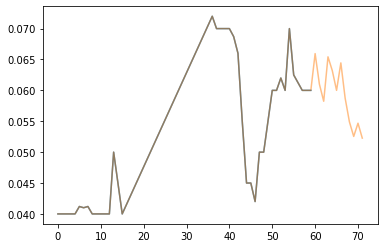

In [279]:
all_coeffs =  list(map(lambda x: sum(x)/len(x), result.get_posterior_mean()))
g = (food_df.Price.values/1e5).tolist()
predicted = g[:]+[0 for _ in range(12)]
'''
for i in range(3, len(g)):
    v = all_coeffs[0]
    v += betas[0] * predicted[i-3]
    v += betas[1] * predicted[i-2]
    v += betas[2] * predicted[i-1]
    #for k in range(5):
        #v += betas[k] * prices[i-k-1]
    predicted[i] = v
    
plt.plot(g)
#dates = item_df.Date.values.tolist()
plt.plot(predicted)
plt.show()
'''
predicted
mu = all_coeffs[0]
phi = all_coeffs[3:0:-1]
theta = all_coeffs[6:3:-1]
sigma = all_coeffs[7]
err = np.random.normal(scale=sigma, size=len(g)+12)
#err = [0 for _ in g]

for i in range(len(g), len(g)+12):
    predicted[i] = mu+np.sum(np.multiply(phi, predicted[i-3:i]))+np.sum(np.multiply(theta, err[i-3:i]))
    #err[i] = g[i]-predicted[i]
plt.plot(g)
plt.plot(predicted, alpha = 0.5)
plt.show()
